In [1]:
#https://www.relataly.com/multi-step-time-series-forecasting-a-step-by-step-guide/275/

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import seaborn as sns
from datetime import date, timedelta,datetime # Date Functions



# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.0
Num GPUs: 0


# Step #1 Load Fin Market Time Series Data

In [2]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'

start_date='2012-01-01'
end_date='2022-12-31'

prediction_col='RSI-MA'

In [3]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date,:]
df=df[[prediction_col]]
print(df.info())
df.tail()


['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2657 entries, 2012-01-04 to 2022-11-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RSI-MA  2657 non-null   float64
dtypes: float64(1)
memory usage: 41.5 KB
None


,RSI-MA
Date,
2022-11-21,53.94
2022-11-22,52.27
2022-11-23,52.66
2022-11-24,53.67
2022-11-25,53.70


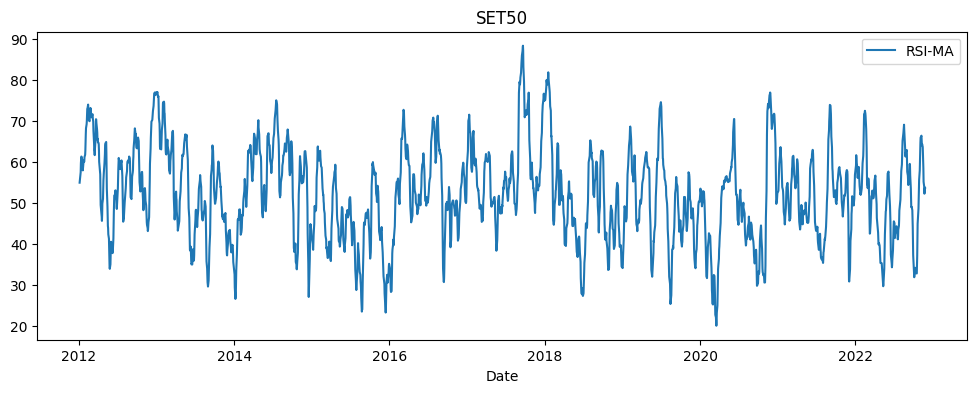

In [4]:
# Visualizing the data
fig, ax1 = plt.subplots(figsize=(12, 4))
plt.title(stockname)
sns.lineplot(data=df, color="green")
plt.legend()
plt.show()

# Step #2 Preprocessing

In [5]:
data = df.copy()

nrows = df.shape[0]
print(f"Get the number of rows in the data = {nrows}")


np_data_unscaled = np.array(df)
print(f"Convert the data to numpy values = {np_data_unscaled.shape}")
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(f"Reshape the data  ={np_data_unscaled.shape}")
print(np_data_unscaled[:5])

Get the number of rows in the data = 2657
Convert the data to numpy values = (2657, 1)
Reshape the data  =(2657, 1)
[[54.95]
 [55.48]
 [55.79]
 [57.51]
 [59.73]]


In [6]:
sequence_length =66
print(f"Set as {sequence_length} sequence length - this is the timeframe used to make a single prediction")
train_ratio=0.9
train_data_len = math.ceil(np_data_unscaled.shape[0] * train_ratio)

# Prediction Index
index_Close = 0

print(f"Split {train_ratio} the training data into train and train data sets")
print(f"Total train ={train_data_len} of {len(np_data_unscaled)} data, we get the number of rows to train the model on 80% of the data")




Set as 66 sequence length - this is the timeframe used to make a single prediction
Split 0.9 the training data into train and train data sets
Total train =2392 of 2657 data, we get the number of rows to train the model on 80% of the data


In [9]:
print("Transform the data by scaling each feature to a range between 0 and 1")
scaler = RobustScaler()
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler(f\)

way=2
if way==1: 
 print("scale then splitefit")
 np_data_scaled = scaler.fit_transform(np_data_unscaled)
 print(f"Scale the data before spliting  ={np_data_scaled.shape}")
 print(np_data_scaled[:5])   
 train_data = np_data_scaled[0:train_data_len, :]
 test_data =  np_data_scaled[train_data_len - sequence_length:, :]
    
else: #way2 
  print("split then scale")  
  train_data = np_data_unscaled[0:train_data_len, :]
  test_data = np_data_unscaled[train_data_len - sequence_length:, :]  
    
  train_data = scaler.fit_transform(train_data)
  test_data=scaler.transform(test_data)
  

print("Create the training and test data")
print(train_data.shape)
print(test_data.shape)   

Transform the data by scaling each feature to a range between 0 and 1
split then scale
Create the training and test data
(2392, 1)
(331, 1)


In [10]:
print("The RNN needs data with the format of [samples, time steps, features]")
print("Here, we create N samples, sequence_length time steps per sample, and n features")
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

print("Generate training data and test data")
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print("Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



The RNN needs data with the format of [samples, time steps, features]
Here, we create N samples, sequence_length time steps per sample, and n features
Generate training data and test data
Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
(2326, 66, 1) (2326,)
(265, 66, 1) (265,)


In [11]:
print(x_train[:2])
print(y_train[:2])
print("Validate that the prediction value and the input match up")
print(f"The last {prediction_col} of the second input sample should equal the first prediction value")
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

[[[0.19716935]
  [0.23165772]
  [0.25183016]
  [0.36375468]
  [0.50821539]
  [0.56157475]
  [0.61102977]
  [0.60972832]
  [0.49324874]
  [0.45810965]
  [0.40865463]
  [0.39238653]
  [0.43077924]
  [0.54986172]
  [0.55636896]
  [0.52643566]
  [0.53814869]
  [0.60387181]
  [0.6390109 ]
  [0.70603546]
  [0.85830486]
  [0.96437286]
  [1.05937856]
  [1.1257524 ]
  [1.17976249]
  [1.28387831]
  [1.36847243]
  [1.37302749]
  [1.43484627]
  [1.36261591]
  [1.31381162]
  [1.20579144]
  [1.18366683]
  [1.17130307]
  [1.27737108]
  [1.2754189 ]
  [1.33658695]
  [1.3814869 ]
  [1.29233773]
  [1.23377257]
  [1.25069139]
  [1.27021311]
  [1.25915081]
  [1.28192614]
  [1.21685375]
  [1.16739873]
  [1.02228729]
  [0.82056288]
  [0.70993981]
  [0.69041809]
  [0.63380511]
  [0.73011225]
  [0.88628599]
  [1.0522206 ]
  [1.20318855]
  [1.20058565]
  [1.14071905]
  [1.04050756]
  [0.98844965]
  [0.87977875]
  [0.89344396]
  [0.83618025]
  [0.82967301]
  [0.80234261]
  [0.70798764]
  [0.52773711]]

 [[0.231

# Step #3 Train the Model

# NStep from prev prediction consquecialy , need 1 step only

In [12]:
epochs = 30; batch_size = 1;
print(f"Configure the neural network model such as epochs ={epochs}  and  batch_size = {batch_size}");

n_neurons = x_train.shape[1] * x_train.shape[2]
print(f"Model with inputshape Timestamps, each with {x_train.shape[1]} variables")

model = Sequential()

# multi laryer
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))

# singer layer
#model.add(LSTM(n_neurons, input_shape=(x_train.shape[1], 1)))


model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")



Configure the neural network model such as epochs =30  and  batch_size = 1
Model with inputshape Timestamps, each with 66 variables


In [13]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,shuffle=False,verbose=2)

Epoch 1/30
2326/2326 [==============================] - 83s 35ms/step - loss: 0.0363
Epoch 2/30
2326/2326 [==============================] - 81s 35ms/step - loss: 0.0069
Epoch 3/30
2326/2326 [==============================] - 78s 34ms/step - loss: 0.0070
Epoch 4/30
2326/2326 [==============================] - 78s 34ms/step - loss: 0.0068
Epoch 5/30
2326/2326 [==============================] - 77s 33ms/step - loss: 0.0062
Epoch 6/30
2326/2326 [==============================] - 82s 35ms/step - loss: 0.0058
Epoch 7/30
2326/2326 [==============================] - 77s 33ms/step - loss: 0.0057
Epoch 8/30
2326/2326 [==============================] - 78s 33ms/step - loss: 0.0057
Epoch 9/30
2326/2326 [==============================] - 79s 34ms/step - loss: 0.0056
Epoch 10/30
2326/2326 [==============================] - 95s 41ms/step - loss: 0.0055
Epoch 11/30
2326/2326 [==============================] - 79s 34ms/step - loss: 0.0051
Epoch 12/30
2326/2326 [==============================] - 76s 33

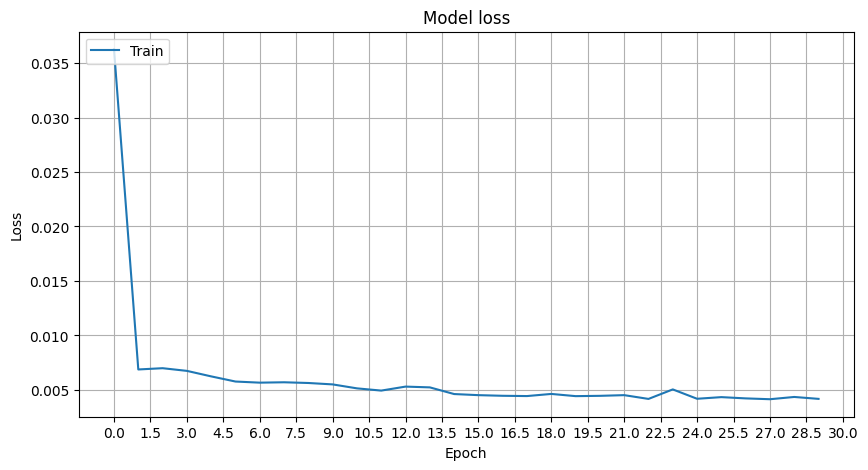

In [14]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

# Step #4 Predicting a Single-step Ahead

In [15]:
x_test_np = np.array(x_test)
x_test_reshape = np.reshape(x_test_np, (x_test_np.shape[0], x_test_np.shape[1], 1))

print(f"Reshape {x_test_np.shape} to be an array with multiple test datasets {x_test_reshape.shape}")
#print(x_test_reshape[:2])

Reshape (265, 66, 1) to be an array with multiple test datasets (265, 66, 1)


In [16]:
y_pred = model.predict(x_test_reshape)
print("Get the predicted values")
print(y_pred[:5])
y_pred_unscaled = scaler.inverse_transform(y_pred)

print("Inverse predicted values")
print(y_pred_unscaled[:5])

y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
print("Inverse y_test values")
print(y_test_unscaled[:5])



9/9 [==============================] - 1s 15ms/step
Get the predicted values
[[ 0.3644468 ]
 [ 0.2174886 ]
 [ 0.15570718]
 [ 0.08991339]
 [-0.0780429 ]]
Inverse predicted values
[[57.520638]
 [55.262257]
 [54.31283 ]
 [53.301743]
 [50.720676]]
Inverse y_test values
[[56.06]
 [54.73]
 [53.81]
 [52.34]
 [50.24]]


In [17]:
RMSE = mean_squared_error(y_test_unscaled, y_pred_unscaled)
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root MEAN Square Error(RMSE): 1.06
Median Absolute Error (MAE): 0.78
Mean Absolute Percentage Error (MAPE): 1.62 %
Median Absolute Percentage Error (MDAPE): 1.17 %


# Step #5 Visualizing Predictions and Loss

In [18]:
print("Visualize the data")
#train = df[:train_data_len]
df_valid_pred = df[train_data_len:]

df_valid_pred.insert(1, "y_pred", y_pred_unscaled, True)

print(df_valid_pred.info())

df_valid_pred.tail()

Visualize the data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 2021-10-25 to 2022-11-25
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RSI-MA  265 non-null    float64
 1   y_pred  265 non-null    float32
dtypes: float32(1), float64(1)
memory usage: 5.2 KB
None


,RSI-MA,y_pred
Date,,
2022-11-21,53.94,52.994263
2022-11-22,52.27,53.867462
2022-11-23,52.66,51.540657
2022-11-24,53.67,53.545090
2022-11-25,53.70,55.552547


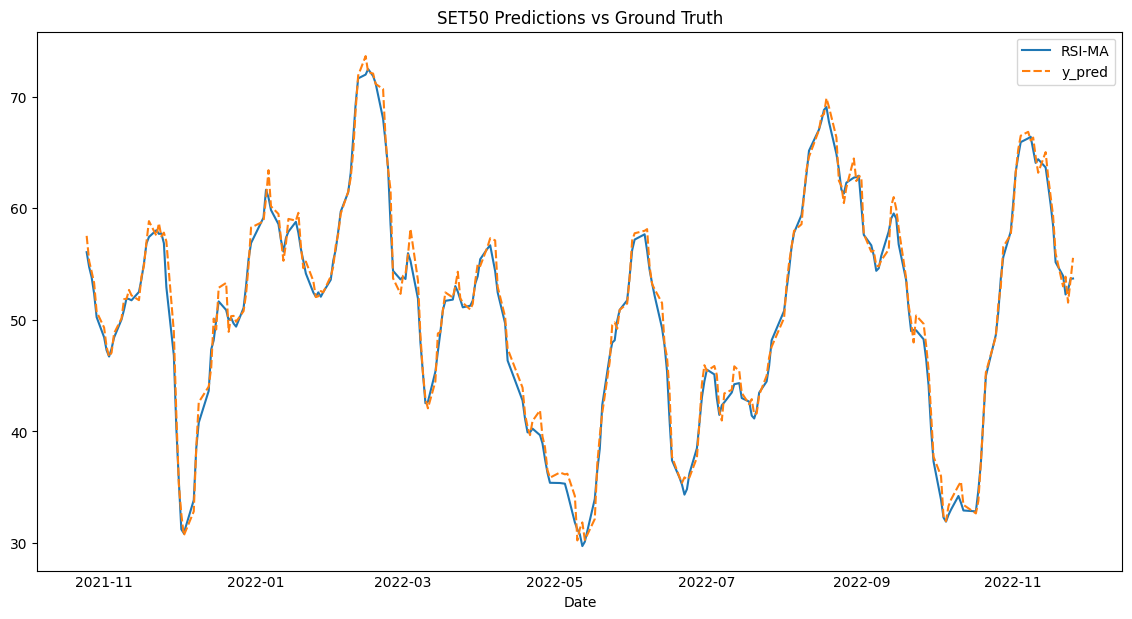

In [19]:
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(14, 7), sharex=True)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title(f"{stockname} Predictions vs Ground Truth")
sns.lineplot(data=df_valid_pred) #  Price and y_pred
plt.show()

# Step #6 Multi-step Time Series Predictions

In [20]:
# Settings and Model Labels
rolling_forecast_range = 10
titletext = f"{sequence_length} Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", n_neurons],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    
    if i < lms - 1:
        settings_text = settings_text + ",  "




In [21]:
# Making a Multi-Step Prediction
# Create the initial input data
new_df = df.filter([prediction_col])
for i in range(0, rolling_forecast_range):
    # Select the last sequence from the dataframe as input for the prediction model
    last_values = new_df[-n_neurons:].values
    
    # Scale the input data and bring it into shape
    last_values_scaled = scaler.transform(last_values)
    X_input = np.array(last_values_scaled).reshape([1, sequence_length, 1])
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    
    # Predict and unscale the predictions
    pred_value = model.predict(X_input)
    pred_value_unscaled = scaler.inverse_transform(pred_value)
    
    # Add the prediction to the next input dataframe
    new_df = pd.concat([new_df, pd.DataFrame({prediction_col: pred_value_unscaled[0, 0]}, index=new_df.iloc[[-1]].index.values + 1)])
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={prediction_col: "Forecast"}
)


1/1 [==============================] - 0s 25ms/step


# Step #6 Visualize the Results

In [22]:
print("Visualize the results")
validxs = df_valid_pred.copy()
dflen = new_df.size - 1
dfs = pd.concat([validxs, forecast], sort=False)

dfs.reset_index(drop=False,inplace=True)
dfs.rename(columns={'index':'Date'},inplace=True)

print(dfs.info())
dfs.tail()

Visualize the results
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      275 non-null    datetime64[ns]
 1   RSI-MA    265 non-null    float64       
 2   y_pred    265 non-null    float32       
 3   Forecast  10 non-null     float64       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 7.6 KB
None


,Date,RSI-MA,y_pred,Forecast
270,2022-11-25 00:00:00.000000006,NaN,NaN,57.030827
271,2022-11-25 00:00:00.000000007,NaN,NaN,58.336563
272,2022-11-25 00:00:00.000000008,NaN,NaN,59.595726
273,2022-11-25 00:00:00.000000009,NaN,NaN,60.954414
274,2022-11-25 00:00:00.000000010,NaN,NaN,62.186665


Zoom in to a closer timeframe 2021-01-01
                             Date  RSI-MA  y_pred   Forecast
270 2022-11-25 00:00:00.000000006     NaN     NaN  57.030827
271 2022-11-25 00:00:00.000000007     NaN     NaN  58.336563
272 2022-11-25 00:00:00.000000008     NaN     NaN  59.595726
273 2022-11-25 00:00:00.000000009     NaN     NaN  60.954414
274 2022-11-25 00:00:00.000000010     NaN     NaN  62.186665


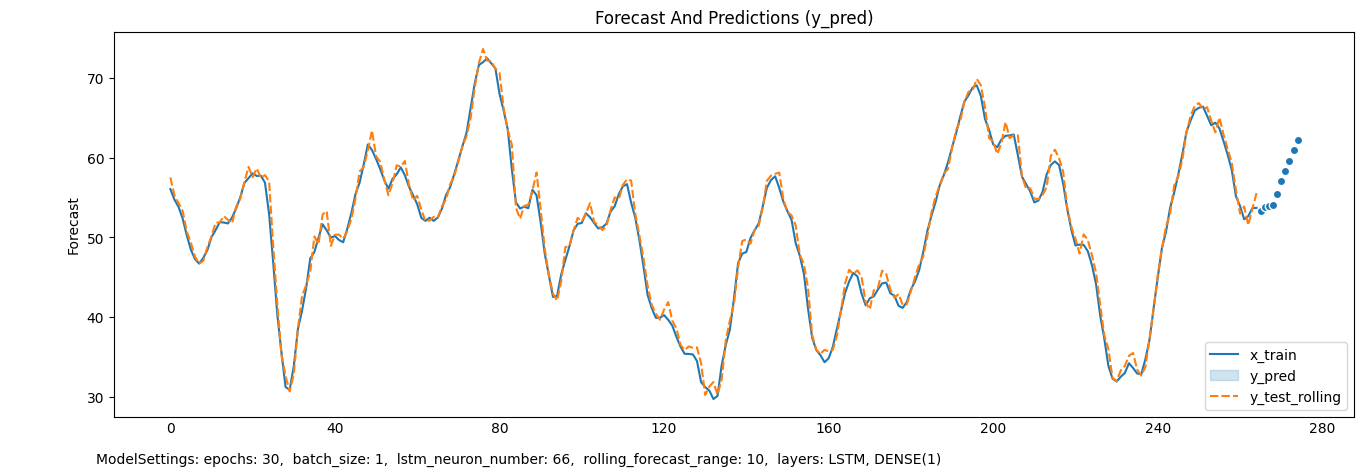

In [23]:
show_date='2021-01-01'
print(f"Zoom in to a closer timeframe {show_date}")
df_zoom = dfs.query('Date>@show_date')
print(df_zoom.tail())

# Visualize the data
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
ax.tick_params(axis="x", rotation=0, labelsize=10, length=0)
ax.xaxis.set_major_locator(plt.MaxNLocator(rolling_forecast_range))
plt.title('Forecast And Predictions (y_pred)')
sns.lineplot(data=df_zoom[[prediction_col, "y_pred"]], ax=ax)
sns.scatterplot(data=df_zoom[["Forecast"]], x=df_zoom.index, y='Forecast', linewidth=1.0, ax=ax)
plt.legend(["x_train", "y_pred", "y_test_rolling"], loc="lower right")
ax.annotate('ModelSettings: ' + settings_text, xy=(0.06, .015),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)
plt.show()
